In [39]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_sample_points_vecs
from models_src.fft_lib import xy_coords, decode1Dcoords, encode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg

from models_src.DETR import FFN, MHA

from models_src.Mask_RCNN import CombinedMetricsModel

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
reload_script('models_src.VecDataset')

In [3]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/vec_detection")
mlflow.tensorflow.autolog(log_datasets=False, log_models=True, disable=True )

In [40]:
class cfg:
    train_batch_size = 32
    val_batch_size = 64
    test_batch_size = 8
    sample_points = 20
    ds_path = './datasets/pixel_similarity'

msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )

dg = DatasetGenerator(msmg, 
                      ds_path='./datasets/pixel_similarity', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_sample_points_vecs, {'n': cfg.sample_points}, True)]
                      )

ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])

ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

In [5]:
class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, splits, axis, **kwargs):
        super().__init__(**kwargs)

        self.splits = splits
        self.axis = axis

    def call(self, inputs):
        return tf.split(inputs, self.splits, self.axis)
    
    @staticmethod
    def _is_iter(x):
        return hasattr(x, '__iter__')
    
    def non_iter_output_shape(self, shape, axis):
        splitted_shape = tuple([d if (i!=axis) | (d is None) else d//self.splits for i,d in enumerate(shape)])
        return tuple([splitted_shape for _ in range(self.splits)])

    def iter_output_shape(self, shape, axis):
        return tuple([tuple([d if (i!=axis) | (d is None) else s for i,d in enumerate(shape)]) for s in self.splits])
    
    def compute_output_shape(self, input_shape):
        axis = self.axis if self.axis>0 else len(input_shape)+self.axis

        if self._is_iter(self.splits):
            output_shape = self.iter_output_shape(input_shape, axis)
        else:
            output_shape = self.non_iter_output_shape(input_shape, axis)

        return output_shape
    
class VecClassSplit(tf.keras.layers.Layer):

    def build(self, input_shape):
        x_shape, splits_shape = input_shape
        self.extra_dims = len(x_shape)-len(splits_shape)


    def call(self, inputs):
        x, splits = inputs[0], inputs[1]
        #splits = splits[...,tf.newaxis, tf.newaxis]
        splits = tf.reshape(splits, tf.concat([tf.shape(splits), tf.ones((self.extra_dims,), tf.int32)], axis=0))
        return tf.concat([x*splits, x*(1-splits)], axis=-2)
    
    def compute_output_shape(self, input_shape):
        x_shape = input_shape[0]
        axis = len(x_shape)-2
        return tuple([d if (i!=axis) | (d is None) else d*2 for i,d in enumerate(x_shape)])
    
class AddNorm(tf.keras.layers.Layer):
    def __init__(self, norm_axis=-1, **kwargs):
        super().__init__(**kwargs)

        self.norm = tf.keras.layers.LayerNormalization(axis=norm_axis)

    def call(self, inputs):
        a, b = inputs[0], inputs[1]
        return self.norm(a+b)
    
class SampleRadialSearchHead(tf.keras.Model):
    def __init__(self, num_samples, ffn_mid_layers, mid_units, activation, dropout=0.0, **kwargs):
        super().__init__(**kwargs)

        self.ffn = FFN(mid_layers=ffn_mid_layers, mid_units=mid_units, output_units=5, dropout=dropout, activation=activation, name=f'{self.name}-Vec-Pred-FFN')
        self.split = SplitLayer(splits=[4,1], axis=-1, name=f'{self.name}-Vec-Class-Split')
        self.squeeze_class = tf.keras.layers.Reshape((num_samples,), name=f'{self.name}-Class-Pred-Squeeze')
        self.class_sigmoid = tf.keras.layers.Activation('sigmoid', name=f'{self.name}-Class-Output')

        self.vec_reshape = tf.keras.layers.Reshape((num_samples, 2,2), name=f'{self.name}-Out-Vec-Reshape')
        self.sample_reshape = tf.keras.layers.Reshape((num_samples, 1,2), name=f'{self.name}Out-Samples-Reshape')
        self.add = tf.keras.layers.Add(name=f'{self.name}-Coords-Add')

        self.vecbbox_split = VecClassSplit(name=f'{self.name}-Vecs-Output')

    def call(self, sample_features, sample_coords, split_mask, training=None):

        x = self.ffn(sample_features, training=training)
        x, class_pred = self.split(x)
        class_pred = self.class_sigmoid(self.squeeze_class(class_pred))

        x = self.vec_reshape(x)
        sample_coords = self.sample_reshape(sample_coords)

        x = self.add([x, sample_coords])
        x = self.vecbbox_split([x, split_mask])

        return x, class_pred
    
class SampleRadialSearchFeaturesExtraction(tf.keras.Model):
    def __init__(self, embs_dim, color_embs_dim, mid_layers, activation, dropout=0.0, batch_dims=1, **kwargs):
        super().__init__(**kwargs)


        features_embs_dim = embs_dim-color_embs_dim
        self.f_ffn = FFN(mid_layers=mid_layers, mid_units=features_embs_dim*2, output_units=features_embs_dim, dropout=dropout, activation=activation, name=f'{self.name}-Memory-FFN')
        self.c_ffn = FFN(mid_layers=mid_layers, mid_units=color_embs_dim*2, output_units=color_embs_dim, dropout=dropout, activation=activation, name=f'{self.name}-ColorEmbs-FFN')

        self.f_concat = tf.keras.layers.Concatenate(name=f'{self.name}-Memory-Color-Concat')
        self.fc_ffn = FFN(mid_layers=mid_layers, mid_units=embs_dim, output_units=embs_dim, dropout=dropout, activation=activation, name=f'{self.name}-Output-Embeddings')

        self.extract_samples = vcm.ExtractSampleLayer(batch_dims=batch_dims, name=f'{self.name}-Extract-Sample')
        self.expand_samples = vcm.ExpandDimsLayer(axis=-2, name=f'{self.name}-Expand-Samples')
        self.squeeze_features = SqueezeImg(name=f'{self.name}-Squeeze-Features')
        self.expand_features = vcm.ExpandDimsLayer(axis=-3, name=f'{self.name}-Expand-Features')
        self.squeeze_enc = SqueezeImg(name=f'{self.name}-Squeeze-PosEnc')

    def call(self, sample_inputs, memory, normed_img, pos_enc, training=None):

        features = self.f_ffn(memory, training=training)
        color_features = self.c_ffn(normed_img, training=training)

        features = self.fc_ffn(self.f_concat([features, color_features]), training=training)
        sample_features = self.expand_samples(self.extract_samples(features, sample_inputs))

        features = self.expand_features(self.squeeze_features(features))
        pos_enc = self.squeeze_enc(pos_enc)

        return features, sample_features, pos_enc
    

In [21]:
def radial_enc_vec_detection_model_generator(
        enc_type,
        num_heads,
        embs_dim,
        color_embs_dim,
        size,
        embs_mid_layers,
        dropout,
        activation,
        out_mid_layers,
        attns_num,
        backbone_args,
        backbone_weights_path,
        backbone_generator,
        backbone_last_layer,
        backbone_init_layer,
        backbone_trainable,
        name='RadVecDet'
):
    
    backbone_model = backbone_generator(**backbone_args)
    if backbone_weights_path is not None:
        backbone_model.load_weights(f'./{backbone_weights_path}.weights.h5')

    backbone_model.trainable = backbone_trainable

    img_inputs = backbone_model.input
    memory = backbone_model.get_layer(backbone_last_layer).output
    normed_img = backbone_model.get_layer(backbone_init_layer).output

    sample_inputs = tf.keras.layers.Input((cfg.sample_points,2), name='sample_points')
    split_inputs = tf.keras.layers.Input((cfg.sample_points,), name='class_split')

    if enc_type=='separate':
        pos_enc = vcm.SeparateRadialEncoding(emb_dim=embs_dim//num_heads, height=size, name='SepRadialEncoding')(sample_inputs)
    else:
        pos_enc = vcm.FrequencyRadialEncoding(emb_dim=embs_dim//num_heads, height=size, name='FreqRadialEnc')(sample_inputs)

    features, sample_features, pos_enc = SampleRadialSearchFeaturesExtraction(embs_dim=embs_dim, 
                                                                            color_embs_dim=color_embs_dim, 
                                                                            mid_layers=embs_mid_layers,
                                                                            activation=activation,
                                                                            dropout=dropout,
                                                                            batch_dims=1,
                                                                            name='SRSFE')(sample_inputs, memory, normed_img, pos_enc)

    print(pos_enc.shape, features.shape, sample_features.shape)

    for i in range(attns_num):
        x, _ = vcm.DetectionMHA(key_pos_enc=(i!=0), output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'MHA_{i+1}')(features, sample_features, features, pos_enc)
        #print(x.shape)
        sample_features = AddNorm(norm_axis=-1, name=f'PostMHA-AddNorm_{i+1}')([sample_features, x])
        x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=embs_dim, dropout=dropout, activation=activation, name=f'Decoder-FFN_{i+1}')(sample_features)
        sample_features = AddNorm(norm_axis=-1, name=f'PostFFN-AddNorm_{i+1}')([sample_features, x])

    vecs, class_preds = SampleRadialSearchHead(num_samples=cfg.sample_points, ffn_mid_layers=out_mid_layers, mid_units=embs_dim*2, activation=activation, dropout=0.0, name='SRShead')(sample_features, sample_inputs, split_inputs)
    vecs = tf.keras.layers.Identity(name='vecs')(vecs)
    class_preds = tf.keras.layers.Identity(name='class')(class_preds)

    model = tf.keras.Model(inputs={'img': img_inputs, 'sample_points': sample_inputs, 'class_split': split_inputs}, 
                           outputs={'vecs': vecs, 'class': class_preds}, 
                           name=name)
    
    return model

# Training

In [46]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

model_args = {
    'enc_type': 'frequency',
    'num_heads': 1,
    'embs_dim': 64,
    'color_embs_dim': 16,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'backbone_args': backbone_args,
    'backbone_generator': vcm.pixel_features_unet,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45_ps',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
}

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {
        'vecs': vcm.MixedBBoxVecLoss(name='VecLoss', gamma=1, reduction='sum_over_batch_size'),
        'class': tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='none', axis=None)
    },
    'loss_weights': {
        'vecs': 0.7,
        'class': 0.3
    }
}

model_generator = radial_enc_vec_detection_model_generator

In [47]:
trainer = TrainingProcessor2(cfg, mlflow_instance=mlflow)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    **compile_args
)

(None, 20, 1024, 64) (None, 1, 1024, 64) (None, 20, 1, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=unet_input> which has name 'unet_input'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


Model: "RadVecDet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unet_input          │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch-Normalization │ (None, 32, 32, 3) │         12 │ unet_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_1         │ [(None, 16, 16,   │    112,576 │ Batch-Normalizat… │
│ (UNetConvBlock)     │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_2         │ [(None, 8, 8,     │    516,608 │ Down-Conv_1[0][0] │
│ (UNetConvBlock)     │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_3         │ [(None, 4, 4,     │  2,065,408 │ Down-Conv_2[0][0] │
│ (UNetConvBlock)     │ 256), (None, 8,   │            │                   │
│                     │ 8, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sample_points       │ (None, 20, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_1           │ (None, 16, 16,    │    868,992 │ Down-Conv_3[0][1… │
│ (UNetUpConvBlock)   │ 128)              │            │ Down-Conv_2[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_2           │ (None, 32, 32,    │    217,408 │ Up-Conv_1[0][0],  │
│ (UNetUpConvBlock)   │ 64)               │            │ Down-Conv_1[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FreqRadialEnc       │ (None, 20, 32,    │          0 │ sample_points[0]… │
│ (FrequencyRadialEn… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SRSFE               │ [(None, 1, 1024,  │     34,400 │ sample_points[0]… │
│ (SampleRadialSearc… │ 64), (None, 20,   │            │ Up-Conv_2[0][0],  │
│                     │ 1, 64), (None,    │            │ Batch-Normalizat… │
│                     │ 20, 1024, 64)]    │            │ FreqRadialEnc[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 32, 32,    │     20,208 │ -                 │
│ SRSFE-Memory-FFN    │ 48)               │            │                   │
│ (FFN)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 32, 32,    │      1,712 │ -                 │
│ SRSFE-ColorEmbs-FFN │ 16)               │            │                   │
│ (FFN)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 32, 32,    │          0 │ -                 │
│ SRSFE-Memory-Color… │ 64)               │            │                   │
│ (Concatenate)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 32, 32,    │     12,480 │ -                 │
│ SRSFE-Output-Embed… │ 64)               │            │                 

 Total params: 3,990,833 (15.22 MB)

 Trainable params: 209,829 (819.64 KB)

 Non-trainable params: 3,781,004 (14.42 MB)

None


In [48]:
trainer.train_model(
    epochs = 40,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=1, decay_ratio=0.95)],
    log = True,
    export_final_state = False,
    export_model = False
)

2024/08/12 13:50:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


MLflow run: thoughtful-vole-355


Epoch 1/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 57s 42ms/step - loss: 5.3514 - val_loss: 4.7887 - learning_rate: 1.0000e-05
Epoch 2/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 3.5820 - val_loss: 2.7408 - learning_rate: 0.0010
Epoch 3/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 2.6547 - val_loss: 2.5893 - learning_rate: 9.5000e-04
Epoch 4/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 2.5209 - val_loss: 2.4716 - learning_rate: 9.0250e-04
Epoch 5/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 2.4232 - val_loss: 2.3927 - learning_rate: 8.5737e-04
Epoch 6/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 2.3534 - val_loss: 2.3762 - learning_rate: 8.1451e-04
Epoch 7/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 2.3144 - val_loss: 2.2946 - learning_rate: 7.7378e-04
Epoch 8/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 2.2853 - val_loss: 2.3713 - learning_rate: 7.3509e-04
Epoch 9/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 2.2617 - val_l

2024-08-12 14:02:07.228033: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2024/08/12 14:02:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpp4f0ohom/model/data/model.


In [49]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

1244.321792

In [50]:
trainer.save_temp_weights('./final_state', filename='e40_base', use_model_name=True)

In [ ]:
trainer.load_temp_weights('final_state/RadVecDet/e30_base', skip_mismatch=False)

In [18]:
mlflow.end_run(status="KILLED")

## Metric Validation

In [51]:
vec_mixed_metric = LossBasedMetric(vcm.MixedBBoxVecLoss(name='VecMixLoss', gamma=1, reduction='none'))
vec_metric = LossBasedMetric(vcm.VecLoss(name='VecLoss', gamma=1, reduction='none'))
bbox_metric = LossBasedMetric(vcm.BBoxVecLoss(name='BBoxLoss', gamma=1, reduction='none'))
class_metric = LossBasedMetric(tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='none', axis=None))

@tf.function(input_signature=[tf.TensorSpec(shape=(cfg.test_batch_size,32,32,3), dtype=tf.float32), 
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,2), dtype=tf.int32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,4,2), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(), dtype=tf.int32),
                              ], 
                              jit_compile=True, autograph=False)
def tf_eval(img, sample_points, class_split, vecs_label, class_label, class_weights, n):
    vecs_pred, class_pred = trainer.model({'img': img, 'sample_points': sample_points, 'class_split': class_split}, training=False).values()
    vec_mixed_metric.update_state(vecs_label, vecs_pred, class_weights)
    class_metric.update_state(class_label, class_pred, class_weights)

    components_mask = tf.where(class_weights>0, 1.0, 0.0)
    B = tf.shape(img)[0]
    vecs_mask = class_split*components_mask
    vecs_num = tf.reduce_sum(vecs_mask, axis=None, keepdims=True)
    vecs_weights = vecs_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), vecs_num)

    bbox_mask = (1-class_split)*components_mask
    bbox_num = tf.reduce_sum(bbox_mask, axis=None, keepdims=True)
    bbox_weights = bbox_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), bbox_num)

    vecs_pred, bbox_pred = tf.split(vecs_pred, 2, axis=-2)
    vecs_label, bbox_label = tf.split(vecs_label, 2, axis=-2)

    vec_metric.update_state(vecs_label, vecs_pred, vecs_weights)
    bbox_metric.update_state(bbox_label, bbox_pred, bbox_weights)

In [52]:
with tf.device('/GPU:0'):
    vec_mixed_metric.reset_state()
    class_metric.reset_state()
    pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['VecMixLoss','VecLoss', 'BBoxLoss', 'ClassLoss'])

    for i in range(test_steps):
        features, labels, labels_weights = next(test_iter)
        img, sample_points, class_split = features.values()
        vecs_labels, components_class = labels.values()
        vecs_weights, class_weights = labels_weights.values()
        tf_eval(img, sample_points, class_split, vecs_labels, components_class, class_weights, cfg.sample_points)
        pb.update(i+1, values=[('VecMixLoss', vec_mixed_metric.result().numpy()),
                               ('VecLoss', vec_metric.result().numpy()),
                               ('BBoxLoss', bbox_metric.result().numpy()),
                               ('ClassLoss', class_metric.result().numpy())])

256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - VecMixLoss: 2.4282 - VecLoss: 3.1707 - BBoxLoss: 1.0814 - ClassLoss: 0.5088


In [53]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    for metric_name, metric_value in zip(['VecMixedLoss', 'VecLoss', 'BBoxLoss', 'ClassLoss'], [m.result().numpy() for m in [vec_mixed_metric, vec_metric, bbox_metric, class_metric]]):
        mlflow.log_metric(metric_name, metric_value)

# Test

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>


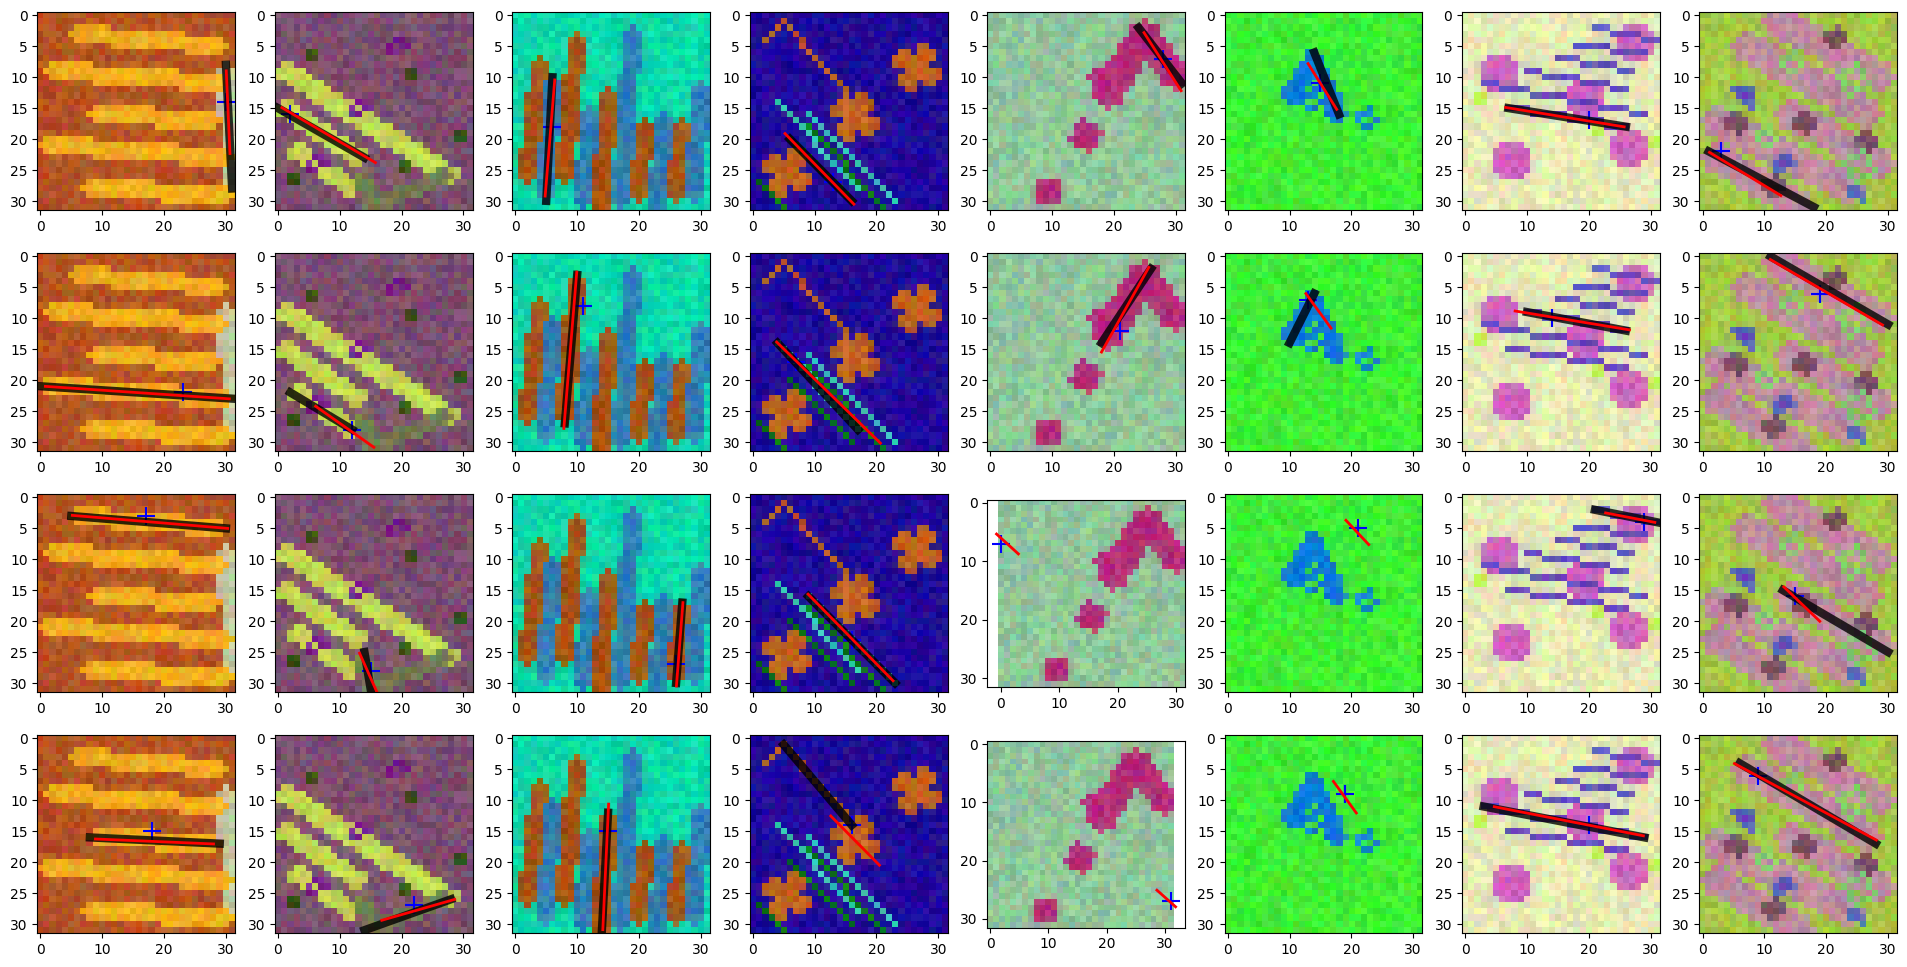

In [54]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)

pred_vecs, pred_class = trainer.model(features, training=False).values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=4
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]
    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r,i]
        ax.imshow(img[i])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
        ax.plot(*i_components[r], color='black', linewidth=6, alpha=0.8)
        ax.plot(*p_components[r], color='red', linewidth=2)